In [3]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs
from src.training.train_cv import build_solution_df
from src.data.dataloader import ForgeryDataset
from src.models.kaggle_metric import score as kaggle_score

plt.style.use("ggplot")

In [4]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

DBG_ROOT = PROJECT_ROOT / "experiments" / "cls_collapse"

### OOF CV results

In [5]:
# List what's in experiments/oof_results/
oof_items = list(OOF_ROOT.iterdir())
oof_dirs = sorted([p.name for p in oof_items if p.is_dir()])
oof_files = sorted([p.name for p in oof_items if p.is_file()])

print("OOF dirs:", oof_dirs)
if oof_files:
    print("OOF loose files:", oof_files)


OOF dirs: ['mini_smoke']
OOF loose files: ['fold_1_oof.csv', 'fold_2_oof.csv', 'fold_3_oof.csv', 'oof_metrics.json', 'oof_predictions.csv', 'sanity_random_200.csv']


In [6]:
def load_run(names):
    """
    names:
      - str: dir name under OOF_ROOT OR filename under OOF_ROOT
      - list/tuple[str]: load multiple; returns dict keyed by run/filename
    """
    if isinstance(names, (list, tuple)):
        return {str(n): load_run(str(n)) for n in names}

    name = str(names)
    p = OOF_ROOT / name

    # Case A: run directory
    if p.is_dir():
        run_dir = p
        oof_csv = run_dir / "oof_predictions.csv"
        metrics_json = run_dir / "oof_metrics.json"

        oof_df = pd.read_csv(oof_csv) if oof_csv.exists() else None
        metrics = json.load(metrics_json.open()) if metrics_json.exists() else None

        fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
        fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

        return {"name": run_dir.name, "path": run_dir, "oof": oof_df, "metrics": metrics, "folds": fold_dfs}

    # Case B: loose file
    if p.is_file():
        if p.suffix.lower() == ".csv":
            return {"name": p.name, "path": p, "oof": pd.read_csv(p), "metrics": None, "folds": {}}
        if p.suffix.lower() == ".json":
            return {"name": p.name, "path": p, "oof": None, "metrics": json.load(p.open()), "folds": {}}
        raise ValueError(f"Unsupported file type: {p.suffix}")

    raise FileNotFoundError(f"Not found under OOF_ROOT: {name}")

# Use load_run(name | [names]) to load one or more CV runs or loose files from experiments/oof_results/
runs = load_run(["mini_smoke"])  # or: load_run("mini_smoke"), load_run("oof_predictions.csv")

print("Loaded:")
if isinstance(runs, dict) and "name" not in runs:
    for k, v in runs.items():
        print(f" - {v['name']} ({v['path']})")
else:
    print(f" - {runs['name']} ({runs['path']})")



Loaded:
 - mini_smoke (C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\mini_smoke)


=== Loaded runs ===

mini_smoke
  Mean CV   : 0.46353349498407265
  OOF score : 0.46353354134165364
  Folds     : [0.46393762183235865, 0.46393762183235865, 0.46296296296296297, 0.4634146341463415, 0.4634146341463415]


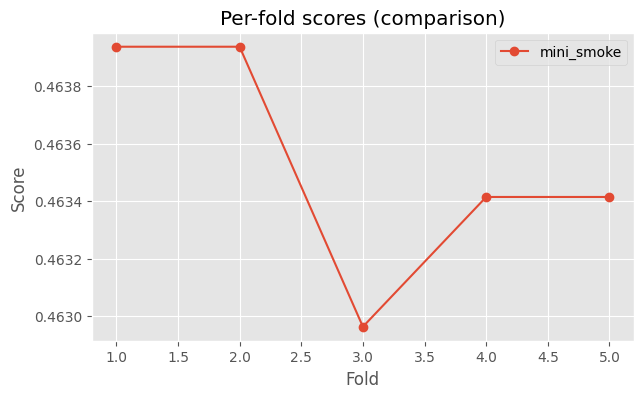

In [7]:
def show_run_metrics(names):
    """
    Pass a run dir name (str) or list of names to compare.
    """
    runs = load_run(names)
    if isinstance(runs, dict) and "name" not in runs:
        items = list(runs.values())
    else:
        items = [runs]

    # Clean summary header
    print("=== Loaded runs ===")
    for r in items:
        m = r["metrics"] or {}
        mean_cv = m.get("mean_cv", None)
        oof_score = m.get("oof_score", None)
        fold_scores = m.get("fold_scores", None)

        print(f"\n{r['name']}")
        print(f"  Mean CV   : {mean_cv}")
        print(f"  OOF score : {oof_score}")
        if fold_scores is not None:
            print(f"  Folds     : {fold_scores}")

    # Comparison plot (only for runs that have fold_scores)
    plot_items = [(r["name"], (r["metrics"] or {}).get("fold_scores")) for r in items]
    plot_items = [(n, fs) for (n, fs) in plot_items if fs is not None]

    if plot_items:
        plt.figure(figsize=(7, 4))
        for name, fs in plot_items:
            plt.plot(range(1, len(fs) + 1), fs, marker="o", label=name)
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.title("Per-fold scores (comparison)")
        plt.legend()
        plt.show()

    return runs

# Single run
_ = show_run_metrics("mini_smoke")

# Compare multiple runs
# _ = show_run_metrics(["mini_smoke", "some_other_run"])



In [8]:
# ---- Use an already-loaded run from `runs` ----
run = runs["mini_smoke"]  # must exist in `runs`

OOF_RUN_DIR = run["path"]
oof_metrics = run["metrics"] or {}
oof_predictions = run["oof"]
fold_dfs = run["folds"]

print("\n== oof_predictions.csv (head) ==")

print("\nFound fold CSVs:", list(fold_dfs.keys()))



== oof_predictions.csv (head) ==

Found fold CSVs: ['fold_1_oof', 'fold_2_oof', 'fold_3_oof', 'fold_4_oof', 'fold_5_oof']


In [11]:
# -------------------------
# 3) Rebuild solution_df and (optionally) re-score to match train_cv
# -------------------------

full_dataset = ForgeryDataset(transform=None)
solution_df = build_solution_df(full_dataset)

# Overall OOF score (ALIGN BY row_id, then score)
solution_df["row_id"] = solution_df["row_id"].astype(str)
oof_predictions["row_id"] = oof_predictions["row_id"].astype(str)
sub_aligned = (
    solution_df[["row_id"]]
    .merge(oof_predictions[["row_id", "annotation"]], on="row_id", how="left")
)

recomputed_oof = kaggle_score(
    solution_df[["row_id", "annotation", "shape"]].copy(),
    sub_aligned[["row_id", "annotation"]].copy(),
    row_id_column_name="row_id",
)

print("\n== Recomputed overall OOF score ==")
print("recomputed_oof:", float(recomputed_oof))

# Per-fold (recompute using the saved fold CSVs if present)
def fold_num_from_stem(stem: str) -> int:
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else -1

if fold_dfs:
    fold_scores = []
    for stem, fdf in sorted(fold_dfs.items(), key=lambda kv: fold_num_from_stem(kv[0])):
        fnum = fold_num_from_stem(stem)

        fold_sol = solution_df[solution_df["row_id"].isin(fdf["row_id"])][["row_id", "annotation", "shape"]].copy()
        fold_sub = (
            fold_sol[["row_id"]]
            .merge(fdf[["row_id", "annotation"]], on="row_id", how="left")
        )

        s = kaggle_score(fold_sol.copy(), fold_sub.copy(), row_id_column_name="row_id")
        fold_scores.append((fnum, float(s)))

    fold_scores_df = pd.DataFrame(fold_scores, columns=["fold", "kaggle_metric"]).sort_values("fold")
    print("\n== Recomputed per-fold scores ==")
    display(fold_scores_df)


== Recomputed overall OOF score ==
recomputed_oof: 0.45923493044822256

== Recomputed per-fold scores ==


,fold,kaggle_metric
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [ ]:
# -------------------------
# 4) Load ClsCollapseLogger outputs for the CV folds (from experiments/cls_collapse)
# -------------------------

def _read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def _read_jsonl(p: Path):
    rows = []
    with open(p, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def _read_table(p: Path):
    suf = p.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(p)
    if suf in (".jsonl", ".ndjson"):
        return _read_jsonl(p)
    return None

def _fold_numbers_from_loaded_run(fold_dfs, oof_metrics):
    nums = []
    for k in (fold_dfs or {}).keys():
        m = re.search(r"(\d+)", str(k))
        if m:
            nums.append(int(m.group(1)))
    if nums:
        return sorted(set(nums))
    fs = (oof_metrics or {}).get("fold_scores", None)
    return list(range(1, len(fs) + 1)) if fs else []

fold_nums = _fold_numbers_from_loaded_run(fold_dfs, oof_metrics)
print("DBG_ROOT:", DBG_ROOT)
print("Folds:", fold_nums)

collapse_json = {}    # (fold, relpath) -> dict
collapse_tables = {}  # (fold, relpath) -> df

for fnum in fold_nums:
    run_name = f"cv_fold{fnum}"
    fold_dir = DBG_ROOT / run_name

    if fold_dir.is_dir():
        files = [p for p in fold_dir.rglob("*") if p.is_file()]
    else:
        files = [p for p in DBG_ROOT.rglob(f"*{run_name}*") if p.is_file()]

    for p in files:
        rel = str(p.relative_to(DBG_ROOT))
        suf = p.suffix.lower()

        if suf == ".json":
            try:
                collapse_json[(fnum, rel)] = _read_json(p)
            except Exception:
                pass
        elif suf in (".csv", ".jsonl", ".ndjson"):
            try:
                df = _read_table(p)
                if df is not None and len(df) > 0:
                    collapse_tables[(fnum, rel)] = df
            except Exception:
                pass

print("\n== ClsCollapseLogger JSON blobs ==")
for (fnum, rel), blob in sorted(collapse_json.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"\n--- fold{fnum} :: {rel} ---")
    print(json.dumps(blob, indent=2)[:4000])

print("\n== ClsCollapseLogger tables ==")
for (fnum, rel), df in sorted(collapse_tables.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"\n--- fold{fnum} :: {rel} ---")
    print("shape:", df.shape, "cols:", list(df.columns))
    display(df.head(10))


In [ ]:




# -------------------------
# 5) Convenience: key summaries across ALL loaded debug tables (no assumptions on filenames)
# -------------------------
def concat_tables(name_contains: str):
    dfs = []
    for (fold, fname), df in all_debug_tables.items():
        if name_contains.lower() in fname.lower():
            d = df.copy()
            d["fold"] = fold
            d["_source"] = fname
            dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

step_losses = concat_tables("step")
epoch_summary = concat_tables("epoch")
debug_events = concat_tables("debug")

if len(step_losses):
    print("\n== step losses (describe) ==")
    display(step_losses.describe(include="all"))

if len(epoch_summary):
    print("\n== epoch summary ==")
    display(epoch_summary)

if len(debug_events):
    print("\n== debug events (sample) ==")
    display(debug_events.head(25))


PROJECT_ROOT: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC
EXP_OOF_ROOT: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results
EXP_DBG_ROOT: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\cls_collapse

OOF_RUN_DIR: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results

== oof_metrics.json ==
{
  "fold_scores": [
    0.45886442641946695,
    0.45971014492753626,
    0.4591304347826087
  ],
  "mean_cv": 0.45923500204320394,
  "oof_score": 0.45923493044822256
}

== oof_predictions.csv (head) ==


,row_id,annotation
0,10,authentic
1,10015,authentic
2,10017,authentic
3,10030,authentic
4,10070,authentic



Found fold CSVs: ['fold_1_oof.csv', 'fold_2_oof.csv', 'fold_3_oof.csv']


,row_id,annotation
0,10030,authentic
1,10070,authentic
2,10139,authentic
3,10152,authentic
4,10266,authentic



== Recomputed overall OOF score ==
recomputed_oof: 0.45923493044822256

== Recomputed per-fold scores ==


,fold,kaggle_metric
0,1,NaN
1,2,NaN
2,3,NaN



Fold debug entrypoints (latest):
  fold1: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\cls_collapse\cv_fold1
  fold2: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\cls_collapse\cv_fold2
  fold3: C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\cls_collapse\cv_fold3

== Debug JSON blobs found ==

--- fold1 :: meta.json ---
{
  "fold": 1,
  "num_folds": 3,
  "device": "cuda",
  "num_epochs": 25,
  "batch_size": 4,
  "lr": 0.0001,
  "weight_decay": 0.0001,
  "out_dir": "experiments/oof_results",
  "model_kwargs": {
    "num_queries": 15,
    "d_model": 256,
    "nhead": 8,
    "num_decoder_layers": 6,
    "dim_feedforward": 2048,
    "dropout": 0.1,
    "activation": "relu",
    "backbone_name": "convnext_tiny",
    "pretrained_backbone": true,
    "backbone_trainable": true,
    "fpn_out_channels": 256,
    "authenticity_penalty_weight": 5.0,
    "auth_gate_forged_threshold": 0.5,
    "default_mask_threshold": 0.5,
    "default_c

,tag,fold,epoch,global_step,img_label,masks_shape,masks_sum,b,Q,Hm,...,class_probs,img_probs,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,rates,max_cls_prob,max_mask_prob
0,batch_target0,1,10.0,7810.0,1.0,"[2, 256, 256]",3757.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,loss_cls_targets,1,10.0,7810.0,NaN,NaN,NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- fold1 :: epoch_summary.csv ---
shape: (100, 11) cols: ['fold', 'epoch', 'epoch_loss', 'cls_max_mean', 'cls_max_p95', 'keep_rate@0.1', 'keep_rate@0.2', 'keep_rate@0.3', 'img_forged_mean', 'mask_max_mean', 'w_mask_cls']


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls
0,1,1,2.021691,0.136009,0.136025,0.733333,0.000000,0.0,0.524097,0.877686,1.0
1,1,2,1.807341,0.130609,0.130677,0.466667,0.000000,0.0,0.532895,1.000000,1.0
2,1,3,1.682340,0.207237,0.207346,0.666667,0.133333,0.0,0.406712,0.999880,1.0
3,1,4,1.619308,0.141077,0.141474,0.400000,0.000000,0.0,0.384231,1.000000,1.0
4,1,5,1.537958,0.122101,0.123965,0.316667,0.000000,0.0,0.350370,1.000000,1.0
5,1,6,1.484385,0.125930,0.127076,0.516667,0.000000,0.0,0.427884,0.999788,1.0
6,1,7,1.461619,0.143643,0.144046,0.333333,0.000000,0.0,0.410432,0.994940,1.0
7,1,8,1.383336,0.104781,0.141810,0.500000,0.000000,0.0,0.331392,0.999974,1.0
8,1,9,1.386051,0.128923,0.130195,0.316667,0.000000,0.0,0.297836,0.999955,1.0
9,1,10,1.347192,0.079287,0.152216,0.150000,0.000000,0.0,0.290729,1.000000,1.0



--- fold1 :: step_losses.csv ---
shape: (86300, 12) cols: ['fold', 'epoch', 'global_step', 'lr', 'loss_mask_bce', 'loss_mask_dice', 'loss_mask_cls', 'loss_img_auth', 'loss_auth_penalty', 'loss_total', 'w_mask_cls', 'w_auth_penalty']


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty
0,1,1,0,0.0001,0.262111,0.995103,0.516458,0.690196,1.713616e-05,2.463886,1.0,1.0
1,1,1,1,0.0001,-0.000000,-0.000000,0.263283,0.725280,1.824594e-13,0.988564,1.0,1.0
2,1,1,2,0.0001,1.822646,1.000000,0.178156,0.708144,4.084136e-15,3.708946,1.0,1.0
3,1,1,3,0.0001,0.034913,0.994669,0.470490,0.686068,1.843080e-16,2.186140,1.0,1.0
4,1,1,4,0.0001,6.495760,0.960591,0.480310,0.712134,0.000000e+00,8.648794,1.0,1.0
5,1,1,5,0.0001,0.181393,0.999938,0.337642,0.682394,2.899051e-18,2.201367,1.0,1.0
6,1,1,6,0.0001,0.232538,1.000000,0.399024,0.709560,4.791375e-24,2.341121,1.0,1.0
7,1,1,7,0.0001,0.056782,0.999993,0.336966,0.701416,2.611014e-18,2.095157,1.0,1.0
8,1,1,8,0.0001,2.111789,0.999999,0.291972,0.674005,5.797576e-23,4.077765,1.0,1.0
9,1,1,9,0.0001,0.483481,0.750133,0.237305,0.698658,4.045081e-22,2.169578,1.0,1.0



--- fold2 :: debug.jsonl ---
shape: (949110, 39) cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'matched', 'reason', 'cost_shape', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob']


,tag,fold,epoch,global_step,img_label,masks_shape,masks_sum,per_image,mask_probs,class_probs,...,per_image_penalty_mean,loss_auth_penalty,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,rates,max_cls_prob,max_mask_prob
0,batch_target0,2,1.0,0.0,0.0,"[0, 256, 256]",0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mask_target_sanity,2,1.0,0.0,NaN,NaN,NaN,"[{'i': 0, 'empty': True}, {'i': 1, 'empty': Fa...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,debug_probs,2,1.0,0.0,NaN,NaN,NaN,NaN,"{'mean': 0.6803867220878601, 'p95': 0.99861907...","{'mean': 0.3655094802379608, 'max': 0.43548023...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hungarian_match_input,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hungarian_match_result,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,hungarian_match_input,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hungarian_match_result,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,hungarian_match_input,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hungarian_match_result,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,hungarian_match_input,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- fold2 :: epoch_summary.csv ---
shape: (100, 11) cols: ['fold', 'epoch', 'epoch_loss', 'cls_max_mean', 'cls_max_p95', 'keep_rate@0.1', 'keep_rate@0.2', 'keep_rate@0.3', 'img_forged_mean', 'mask_max_mean', 'w_mask_cls']


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls
0,2,1,1.979803,0.079369,0.079380,0.0,0.0,0.0,0.556308,0.482542,1.0
1,2,2,1.829520,0.081784,0.081788,0.0,0.0,0.0,0.109322,0.788050,1.0
2,2,3,1.703050,0.127818,0.127826,1.0,0.0,0.0,0.436586,0.922487,1.0
3,2,4,1.648878,0.105230,0.105235,1.0,0.0,0.0,0.031734,0.425272,1.0
4,2,5,1.590258,0.104061,0.104066,1.0,0.0,0.0,0.194760,0.497356,1.0
5,2,6,1.542239,0.093530,0.093534,0.0,0.0,0.0,0.012607,0.870392,1.0
6,2,7,1.533790,0.111282,0.111284,1.0,0.0,0.0,0.056348,0.861015,1.0
7,2,8,1.478707,0.093523,0.093526,0.0,0.0,0.0,0.047952,0.913575,1.0
8,2,9,1.450438,0.105415,0.105418,1.0,0.0,0.0,0.053296,0.751841,1.0
9,2,10,1.419395,0.083595,0.083599,0.0,0.0,0.0,0.037501,0.217620,1.0



--- fold2 :: step_losses.csv ---
shape: (86300, 12) cols: ['fold', 'epoch', 'global_step', 'lr', 'loss_mask_bce', 'loss_mask_dice', 'loss_mask_cls', 'loss_img_auth', 'loss_auth_penalty', 'loss_total', 'w_mask_cls', 'w_auth_penalty']


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty
0,2,1,0,0.0001,1.031623,0.951627,0.549513,0.706058,7.664661e-05,3.238897,1.0,1.0
1,2,1,1,0.0001,1.314601,1.000000,0.679744,0.703960,7.352732e-09,3.698305,1.0,1.0
2,2,1,2,0.0001,0.649692,1.000000,0.564674,0.703488,0.000000e+00,2.917854,1.0,1.0
3,2,1,3,0.0001,0.070159,0.997479,0.349264,0.694047,2.239285e-10,2.110949,1.0,1.0
4,2,1,4,0.0001,0.099659,0.973495,0.562179,0.687035,0.000000e+00,2.322369,1.0,1.0
5,2,1,5,0.0001,0.133979,0.996455,0.186098,0.697139,6.782530e-12,2.013670,1.0,1.0
6,2,1,6,0.0001,0.228618,0.992702,0.286424,0.696731,1.505094e-13,2.204476,1.0,1.0
7,2,1,7,0.0001,0.046608,0.999909,0.331437,0.688273,2.555729e-15,2.066227,1.0,1.0
8,2,1,8,0.0001,0.351501,0.998994,0.246101,0.697909,7.036084e-17,2.294505,1.0,1.0
9,2,1,9,0.0001,0.060453,0.996041,0.341994,0.687710,7.688776e-17,2.086197,1.0,1.0



--- fold3 :: debug.jsonl ---
shape: (949110, 39) cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob']


,tag,fold,epoch,global_step,img_label,masks_shape,masks_sum,per_image,mask_probs,class_probs,...,loss_auth_penalty,reason,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,rates,max_cls_prob,max_mask_prob
0,batch_target0,3,1.0,0.0,1.0,"[2, 256, 256]",27657.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mask_target_sanity,3,1.0,0.0,NaN,NaN,NaN,"[{'i': 0, 'empty': False, 'mean_per_inst': [0....",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,debug_probs,3,1.0,0.0,NaN,NaN,NaN,NaN,"{'mean': 0.034498389810323715, 'p95': 0.195016...","{'mean': 0.4910903573036194, 'max': 0.57787221...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hungarian_match_input,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hungarian_match_result,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,hungarian_match_input,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hungarian_match_result,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,hungarian_match_input,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hungarian_match_result,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,hungarian_match_input,3,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- fold3 :: epoch_summary.csv ---
shape: (100, 11) cols: ['fold', 'epoch', 'epoch_loss', 'cls_max_mean', 'cls_max_p95', 'keep_rate@0.1', 'keep_rate@0.2', 'keep_rate@0.3', 'img_forged_mean', 'mask_max_mean', 'w_mask_cls']


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls
0,3,1,2.006901,0.100625,0.100664,0.200000,0.0,0.0,0.557023,0.456094,1.0
1,3,2,1.840410,0.085682,0.085742,0.000000,0.0,0.0,0.556329,0.420990,1.0
2,3,3,1.712696,0.109076,0.109310,1.000000,0.0,0.0,0.477975,0.688401,1.0
3,3,4,1.609693,0.107502,0.107627,1.000000,0.0,0.0,0.458665,0.868019,1.0
4,3,5,1.573421,0.050981,0.059329,0.000000,0.0,0.0,0.372914,0.911569,1.0
5,3,6,1.528838,0.142077,0.143167,1.000000,0.0,0.0,0.711251,0.420575,1.0
6,3,7,1.493325,0.090637,0.143128,0.250000,0.0,0.0,0.280934,0.406260,1.0
7,3,8,1.455060,0.061112,0.135202,0.250000,0.0,0.0,0.378042,0.978942,1.0
8,3,9,1.447085,0.045231,0.090346,0.116667,0.0,0.0,0.220055,0.659700,1.0
9,3,10,1.404310,0.119335,0.148803,0.750000,0.0,0.0,0.360466,0.738125,1.0



--- fold3 :: step_losses.csv ---
shape: (86300, 12) cols: ['fold', 'epoch', 'global_step', 'lr', 'loss_mask_bce', 'loss_mask_dice', 'loss_mask_cls', 'loss_img_auth', 'loss_auth_penalty', 'loss_total', 'w_mask_cls', 'w_auth_penalty']


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty
0,3,1,0,0.0001,0.429242,0.941070,0.688064,0.714919,0.000000e+00,2.773294,1.0,1.0
1,3,1,1,0.0001,18.923695,0.919481,0.323817,0.703806,6.716571e-11,20.870800,1.0,1.0
2,3,1,2,0.0001,0.432901,0.999802,0.449078,0.688007,2.103209e-14,2.569788,1.0,1.0
3,3,1,3,0.0001,0.627139,0.999999,0.340745,0.677557,2.322676e-15,2.645441,1.0,1.0
4,3,1,4,0.0001,-0.000000,-0.000000,0.166593,0.696139,7.184600e-14,0.862732,1.0,1.0
5,3,1,5,0.0001,0.019350,0.999970,0.198464,0.715327,2.079819e-13,1.933110,1.0,1.0
6,3,1,6,0.0001,0.119702,0.998191,0.244691,0.693342,1.122470e-14,2.055927,1.0,1.0
7,3,1,7,0.0001,0.067135,0.944978,0.241027,0.697592,1.325485e-14,1.950731,1.0,1.0
8,3,1,8,0.0001,0.314613,0.980428,0.384145,0.701282,9.958815e-15,2.380467,1.0,1.0
9,3,1,9,0.0001,0.265864,0.976314,0.534140,0.694927,5.607082e-17,2.471246,1.0,1.0



== step losses (describe) ==


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty,_source
count,258900.000000,258900.000000,258900.00000,2.589000e+05,258900.000000,258900.000000,258900.000000,258900.000000,2.589000e+05,258900.000000,258900.0,258900.0,258900
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,step_losses.csv
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258900
mean,2.000000,13.000000,10787.00000,1.000000e-04,0.094483,0.590153,0.297259,0.413005,1.633224e-09,1.394900,1.0,1.0,NaN
std,0.816498,7.211116,6228.17805,4.065766e-20,0.146163,0.232428,0.138332,0.265557,3.508879e-07,0.480522,0.0,0.0,NaN
min,1.000000,1.000000,0.00000,1.000000e-04,-0.000000,-0.000000,0.001061,0.000032,0.000000e+00,0.006600,1.0,1.0,NaN
25%,1.000000,7.000000,5393.00000,1.000000e-04,0.031496,0.453132,0.195561,0.217966,1.197186e-16,1.075213,1.0,1.0,NaN
50%,2.000000,13.000000,10787.00000,1.000000e-04,0.066003,0.604315,0.281244,0.374828,9.152119e-14,1.386458,1.0,1.0,NaN
75%,3.000000,19.000000,16181.00000,1.000000e-04,0.121420,0.757001,0.384913,0.570591,1.167364e-12,1.710075,1.0,1.0,NaN



== epoch summary ==


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls,_source
0,1,1,2.021691,0.136009,0.136025,0.733333,0.000000,0.0,0.524097,0.877686,1.0,epoch_summary.csv
1,1,2,1.807341,0.130609,0.130677,0.466667,0.000000,0.0,0.532895,1.000000,1.0,epoch_summary.csv
2,1,3,1.682340,0.207237,0.207346,0.666667,0.133333,0.0,0.406712,0.999880,1.0,epoch_summary.csv
3,1,4,1.619308,0.141077,0.141474,0.400000,0.000000,0.0,0.384231,1.000000,1.0,epoch_summary.csv
4,1,5,1.537958,0.122101,0.123965,0.316667,0.000000,0.0,0.350370,1.000000,1.0,epoch_summary.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
295,3,21,1.150822,0.042312,0.042312,0.000000,0.000000,0.0,0.018900,0.199851,1.0,epoch_summary.csv
296,3,22,1.130714,0.043384,0.043384,0.000000,0.000000,0.0,0.035956,0.786976,1.0,epoch_summary.csv
297,3,23,1.116158,0.047295,0.047295,0.000000,0.000000,0.0,0.062320,0.717211,1.0,epoch_summary.csv
298,3,24,1.106020,0.049462,0.049462,0.000000,0.000000,0.0,0.286953,0.750742,1.0,epoch_summary.csv



== debug events (sample) ==


,tag,fold,epoch,global_step,img_label,masks_shape,masks_sum,b,Q,Hm,...,img_probs,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,rates,max_cls_prob,max_mask_prob,_source
0,batch_target0,1,10.0,7810.0,1.0,"[2, 256, 256]",3757.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
1,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
2,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,0.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
3,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
4,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,1.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
5,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
6,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,2.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
7,hungarian_match_input,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
8,hungarian_match_result,1,10.0,7810.0,NaN,NaN,NaN,3.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl
9,loss_cls_targets,1,10.0,7810.0,NaN,NaN,NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debug.jsonl


In [ ]:
# show exactly what debug tables were loaded + their columns
for (fold, fname), df in sorted(all_debug_tables.items(), key=lambda x: (x[0][0], x[0][1])):
    print(f"\nfold{fold} :: {fname} :: shape={df.shape}")
    print("cols:", list(df.columns))


fold1 :: debug.jsonl :: shape=(625807, 39)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob']

fold1 :: epoch_summary.csv :: shape=(100, 11)
cols: ['fold', 'epoch', 'epoch_loss', 'cls_max_mean', 'cls_max_p95', 'keep_rate@0.1', 'keep_rate@0.2', 'keep_rate@0.3', 'img_forged_mean', 'mask_max_mean', 'w_mask_cls']

fold1 :: step_losses.csv :: shape=(86300, 12)
cols: ['fold', 'epoch', 'global_step', 'lr', 'loss_mask_bce', 'loss_mask_dice', 'loss_mask_cls', 'loss_img_auth', 'loss_auth_penalty', 'loss_total', 'w_mask_cls', 'w_auth_penalty']

fold2 :: debug.jsonl :: shape=

In [ ]:
import pandas as pd

# 1) Collect debug.jsonl from all folds
dbg_parts = []
for (fold, fname), df in all_debug_tables.items():
    if fname.lower() == "debug.jsonl":
        d = df.copy()
        d["fold_src"] = fold
        dbg_parts.append(d)

dbg = pd.concat(dbg_parts, ignore_index=True)
print("dbg shape:", dbg.shape)
print("cols:", list(dbg.columns))

# Coerce numeric cols that may have been logged as strings/objects
for c in ["max_cls_prob", "max_mask_prob", "thr", "temp"]:
    if c in dbg.columns:
        dbg[c] = pd.to_numeric(dbg[c], errors="coerce")

# Also ensure flags are boolean-ish (sometimes logged as 0/1 or "True"/"False")
for c in ["masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg"]:
    if c in dbg.columns:
        if dbg[c].dtype == object:
            dbg[c] = dbg[c].astype(str).str.lower().isin(["true", "1", "yes"])
        else:
            dbg[c] = dbg[c].astype(bool)

# 2) Optional: restrict to inference-only rows if your logger mixes tags
# (keep this even if you’re unsure; it’s safe)
if "tag" in dbg.columns:
    infer = dbg[dbg["tag"].astype(str).str.contains("infer", case=False, na=False)].copy()
    if len(infer) > 0:
        dbg = infer
        print("Filtered to infer-tag rows:", dbg.shape)

# 3) Global counts
total = len(dbg)
stats = {
    "total_rows": total,
    "masks_numel_eq_0": int(dbg["masks_empty"].sum()),
    "gate_pass_false": int(dbg["gate_fail"].sum()),
    "num_keep_eq_0": int(dbg["num_keep0"].sum()),
    "fg_pre_true_post_false": int(dbg["cls_filtered_all_fg"].sum()),
}
stats_df = pd.Series(stats, name="count").to_frame()
stats_df["fraction"] = stats_df["count"] / total
display(stats_df)


# 4) Per-fold counts
def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.quantile(0.95)) if len(x) else np.nan

per_fold = (
    dbg.groupby("fold", dropna=False)
       .agg(
            rows=("fold", "size"),
            masks_numel_eq_0=("masks_empty", "sum"),
            gate_pass_false=("gate_fail", "sum"),
            num_keep_eq_0=("num_keep0", "sum"),
            fg_pre_true_post_false=("cls_filtered_all_fg", "sum"),
            max_cls_prob_mean=("max_cls_prob", "mean"),
            max_cls_prob_p95=("max_cls_prob", p95),
            max_mask_prob_mean=("max_mask_prob", "mean"),
            max_mask_prob_p95=("max_mask_prob", p95),
        )
       .reset_index()
       .sort_values("fold")
)
display(per_fold)


# 5) Inspect the “cls_threshold filtered everything” rows
suspect = dbg[dbg["cls_filtered_all_fg"] == True][
    ["fold", "epoch", "global_step", "img_label", "masks_empty", "gate_fail", "num_keep0",
     "max_cls_prob", "max_mask_prob", "thr", "temp", "reason"]
].copy()

print("suspect rows:", len(suspect))
display(suspect.head(50))


dbg shape: (2524027, 40)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'B', 'pos', 'total', 'pos_frac', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'reason', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'rates', 'max_cls_prob', 'max_mask_prob', 'fold_src']
Filtered to infer-tag rows: (6, 40)


,count,fraction
total_rows,6,1.0
masks_numel_eq_0,6,1.0
gate_pass_false,6,1.0
num_keep_eq_0,6,1.0
fg_pre_true_post_false,6,1.0


,fold,rows,masks_numel_eq_0,gate_pass_false,num_keep_eq_0,fg_pre_true_post_false,max_cls_prob_mean,max_cls_prob_p95,max_mask_prob_mean,max_mask_prob_p95
0,1,2,2,2,2,2,NaN,NaN,NaN,NaN
1,2,2,2,2,2,2,NaN,NaN,NaN,NaN
2,3,2,2,2,2,2,NaN,NaN,NaN,NaN


suspect rows: 6


,fold,epoch,global_step,img_label,masks_empty,gate_fail,num_keep0,max_cls_prob,max_mask_prob,thr,temp,reason
388578,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
625806,1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
1337638,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
1574916,2,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2286748,3,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN
2524026,3,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
from pathlib import Path

# Adjust if your experiment root differs
EXP_ROOT = Path("../experiments")

csvs = sorted(EXP_ROOT.rglob("sanity_random_200.csv"))
assert len(csvs) > 0, "No sanity_random_200.csv found"

df = pd.read_csv(csvs[-1])  # load most recent
display(df.head())

# Quick sanity summaries
summary = {
    "rows": len(df),
    "forged_folder_rate": df["is_forged_folder"].mean(),
    "image_label_rate": df["image_label"].mean(),
    "any_instances_rate": (df["num_instances"] > 0).mean(),
    "mean_union_sum": df["union_sum"].mean(),
    "mean_max_instance_sum": df["max_instance_sum"].mean(),
}

pd.Series(summary).to_frame("value")


,idx,is_forged_folder,image_label,num_instances,union_sum,max_instance_sum
0,1868,False,0.0,0,0,0
1,2593,True,1.0,1,1132,1132
2,2303,False,0.0,0,0,0
3,463,False,0.0,0,0,0
4,462,False,0.0,0,0,0


,value
rows,200.000
forged_folder_rate,0.545
image_label_rate,0.545
any_instances_rate,0.545
mean_union_sum,30973.545
mean_max_instance_sum,26154.455


In [ ]:
# Cross-tab: are forged-folder images ever labeled authentic?
pd.crosstab(df["is_forged_folder"], df["image_label"])




image_label,0.0,1.0
is_forged_folder,,
False,91,0
True,0,109


In [ ]:
# How often do we have forged-folder but zero instances?
df.query("is_forged_folder == True and num_instances == 0").shape[0]

0